In [1]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import numpy as np
import scipy.io as sio
from numpy import expand_dims
from numpy import asarray
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from skimage.filters import gabor_kernel
from scipy import ndimage as nd        
import matplotlib
import matplotlib.pyplot as plt    
from numpy.linalg import norm
from keras.optimizers import SGD, Adam, Adagrad
import graphviz
import pydot

In [2]:
data_path = 'E:/Sushree/Dataset/'

img_path = os.path.join(data_path,'CUB_200_2011/CUB_200_2011/images/')
print(img_path)

print(len(os.listdir(img_path)))

def get_imlist(path, option):
    if option == 'jpg':
        return[os.path.join(path, f) for f in os.listdir(path) if f.endswith('.jpg')]
    
def prepare_dataset(img_path, width, height, option):
    folder_list = os.listdir(img_path)
    num_classes = len(folder_list)
    images = []
    labels = []
    for i in range(len(folder_list)):
        print(i)
        img_list = get_imlist(os.path.join(img_path, folder_list[i]), option)
        for j in range(len(img_list)):
            img = image.load_img(img_list[j], target_size = (width, height))
            img = np.array(img)
            #img = np.true_divide(img,[255.0], out = None)
            img = np.divide(np.subtract(img, np.mean(img)), np.std(img))
            x = image.img_to_array(img)
            images.append(x)
            labels.append(i)
    images = np.array(images, dtype = np.float32)                             
    labels = to_categorical(labels, num_classes)                             
    return images, labels  


width, height, ch = 224, 224, 3
images, labels = prepare_dataset(img_path, width, height,'jpg')

print(images.shape)
print(len(labels))

E:/Sushree/Dataset/CUB_200_2011/CUB_200_2011/images/
200
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
(11788, 224, 224, 3)
11788


In [3]:

split_path = os.path.join(data_path,'data/xlsa17/data/CUB/att_splits.mat')
matcontent = sio.loadmat(split_path)
trainval_loc = matcontent['trainval_loc'].squeeze() - 1

print(trainval_loc, len(trainval_loc))

train_images = images[trainval_loc]
print(train_images.shape)

train_labels = labels[trainval_loc]
print(train_labels, train_labels.shape)


[10876 10920  2652 ...  5226 11507  1642] 7057
(7057, 224, 224, 3)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (7057, 200)


In [4]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size = 0.2, random_state = 42)

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

batch_size = 16
train_gen = DataGenerator(X_train, y_train, batch_size)   
val_gen = DataGenerator(X_val, y_val, batch_size)

In [5]:
model = tf.keras.applications.resnet.ResNet101(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000
)

model.summary()

# define new_model, with an additional dense(1024) layer after global average pooling  
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
pred = Dense(200, activation='softmax')(x)

new_model = Model(inputs = model.input, outputs = pred)
new_model.summary()


for layer in new_model.layers:
    layer.trainable = True
    

sgd = SGD(learning_rate = 1e-2, decay = 1e-6, momentum = 0.9, nesterov = True)
new_model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

train_summary = new_model.fit(train_gen, epochs = 200, verbose = 1, callbacks = None, validation_data = val_gen, 
                              shuffle = True, steps_per_epoch = len(train_gen)//batch_size, 
                              validation_steps = len(val_gen)//batch_size)
    

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                       

                                                                                                  
 conv2_block2_add (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, None, None,   0           ['conv2_block2_add[0][0]']       
                                256)                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, None, None,   16448       ['conv2_block2_out[0][0]']       
                                64)                                                               
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_2_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, None, None,   0          ['conv3_block2_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block2_2_relu[0][0]']    
                                512)                                                              
          

 conv4_block1_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, None, None,   0          ['conv4_block1_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block1_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       1024)                                                             
                                                                                                  
 conv4_block3_add (Add)         (None, None, None,   0           ['conv4_block2_out[0][0]',       
                                1024)                             'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, None, None,   0           ['conv4_block3_add[0][0]']       
                                1024)                                                             
                                                                                                  
 conv4_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, None, None,   0          ['conv4_block6_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block6_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block6_3_conv[0][0]']    
 ization)                       1024)                                                             
          

 conv4_block9_1_relu (Activatio  (None, None, None,   0          ['conv4_block9_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block9_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block9_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block9_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block9_2_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block9_2_relu (Activatio  (None, None, None,   0          ['conv4_block9_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block12_1_conv (Conv2D)  (None, None, None,   262400      ['conv4_block11_out[0][0]']      
                                256)                                                              
                                                                                                  
 conv4_block12_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block12_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block12_1_relu (Activati  (None, None, None,   0          ['conv4_block12_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_blo

 lization)                      1024)                                                             
                                                                                                  
 conv4_block14_add (Add)        (None, None, None,   0           ['conv4_block13_out[0][0]',      
                                1024)                             'conv4_block14_3_bn[0][0]']     
                                                                                                  
 conv4_block14_out (Activation)  (None, None, None,   0          ['conv4_block14_add[0][0]']      
                                1024)                                                             
                                                                                                  
 conv4_block15_1_conv (Conv2D)  (None, None, None,   262400      ['conv4_block14_out[0][0]']      
                                256)                                                              
          

 conv4_block17_2_relu (Activati  (None, None, None,   0          ['conv4_block17_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block17_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block17_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block17_3_bn (BatchNorma  (None, None, None,   4096       ['conv4_block17_3_conv[0][0]']   
 lization)                      1024)                                                             
                                                                                                  
 conv4_block17_add (Add)        (None, None, None,   0           ['conv4_block16_out[0][0]',      
          

                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, None, None,   590080      ['conv4_block20_1_relu[0][0]']   
                                256)                                                              
                                                                                                  
 conv4_block20_2_bn (BatchNorma  (None, None, None,   1024       ['conv4_block20_2_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block20_2_relu (Activati  (None, None, None,   0          ['conv4_block20_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_blo

                                256)                                                              
                                                                                                  
 conv4_block23_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block23_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block23_1_relu (Activati  (None, None, None,   0          ['conv4_block23_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block23_2_conv (Conv2D)  (None, None, None,   590080      ['conv4_block23_1_relu[0][0]']   
                                256)                                                              
          

 conv5_block2_3_conv (Conv2D)   (None, None, None,   1050624     ['conv5_block2_2_relu[0][0]']    
                                2048)                                                             
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, None, None,   8192       ['conv5_block2_3_conv[0][0]']    
 ization)                       2048)                                                             
                                                                                                  
 conv5_block2_add (Add)         (None, None, None,   0           ['conv5_block1_out[0][0]',       
                                2048)                             'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, None, None,   0           ['conv5_block2_add[0][0]']       
          

                                                                                                  
 conv2_block1_2_relu (Activatio  (None, None, None,   0          ['conv2_block1_2_bn[0][0]']      
 n)                             64)                                                               
                                                                                                  
 conv2_block1_0_conv (Conv2D)   (None, None, None,   16640       ['pool1_pool[0][0]']             
                                256)                                                              
                                                                                                  
 conv2_block1_3_conv (Conv2D)   (None, None, None,   16640       ['conv2_block1_2_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block1_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, None, None,   0          ['conv3_block1_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block1_2_conv (Conv2D)   (None, None, None,   147584      ['conv3_block1_1_relu[0][0]']    
                                128)                                                              
          

 conv3_block3_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block3_2_relu[0][0]']    
                                512)                                                              
                                                                                                  
 conv3_block3_3_bn (BatchNormal  (None, None, None,   2048       ['conv3_block3_3_conv[0][0]']    
 ization)                       512)                                                              
                                                                                                  
 conv3_block3_add (Add)         (None, None, None,   0           ['conv3_block2_out[0][0]',       
                                512)                              'conv3_block3_3_bn[0][0]']      
                                                                                                  
 conv3_block3_out (Activation)  (None, None, None,   0           ['conv3_block3_add[0][0]']       
          

                                                                                                  
 conv4_block2_1_relu (Activatio  (None, None, None,   0          ['conv4_block2_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block2_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block2_2_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_blo

                                1024)                                                             
                                                                                                  
 conv4_block5_1_conv (Conv2D)   (None, None, None,   262400      ['conv4_block4_out[0][0]']       
                                256)                                                              
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block5_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, None, None,   0          ['conv4_block5_1_bn[0][0]']      
 n)                             256)                                                              
          

 conv4_block7_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block7_3_conv[0][0]']    
 ization)                       1024)                                                             
                                                                                                  
 conv4_block7_add (Add)         (None, None, None,   0           ['conv4_block6_out[0][0]',       
                                1024)                             'conv4_block7_3_bn[0][0]']      
                                                                                                  
 conv4_block7_out (Activation)  (None, None, None,   0           ['conv4_block7_add[0][0]']       
                                1024)                                                             
                                                                                                  
 conv4_block8_1_conv (Conv2D)   (None, None, None,   262400      ['conv4_block7_out[0][0]']       
          

                                                                                                  
 conv4_block10_2_relu (Activati  (None, None, None,   0          ['conv4_block10_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block10_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block10_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block10_3_bn (BatchNorma  (None, None, None,   4096       ['conv4_block10_3_conv[0][0]']   
 lization)                      1024)                                                             
                                                                                                  
 conv4_blo

 on)                            256)                                                              
                                                                                                  
 conv4_block13_2_conv (Conv2D)  (None, None, None,   590080      ['conv4_block13_1_relu[0][0]']   
                                256)                                                              
                                                                                                  
 conv4_block13_2_bn (BatchNorma  (None, None, None,   1024       ['conv4_block13_2_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block13_2_relu (Activati  (None, None, None,   0          ['conv4_block13_2_bn[0][0]']     
 on)                            256)                                                              
          

 conv4_block16_1_conv (Conv2D)  (None, None, None,   262400      ['conv4_block15_out[0][0]']      
                                256)                                                              
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block16_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block16_1_relu (Activati  (None, None, None,   0          ['conv4_block16_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block16_2_conv (Conv2D)  (None, None, None,   590080      ['conv4_block16_1_relu[0][0]']   
          

                                                                                                  
 conv4_block18_add (Add)        (None, None, None,   0           ['conv4_block17_out[0][0]',      
                                1024)                             'conv4_block18_3_bn[0][0]']     
                                                                                                  
 conv4_block18_out (Activation)  (None, None, None,   0          ['conv4_block18_add[0][0]']      
                                1024)                                                             
                                                                                                  
 conv4_block19_1_conv (Conv2D)  (None, None, None,   262400      ['conv4_block18_out[0][0]']      
                                256)                                                              
                                                                                                  
 conv4_blo

 on)                            256)                                                              
                                                                                                  
 conv4_block21_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block21_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block21_3_bn (BatchNorma  (None, None, None,   4096       ['conv4_block21_3_conv[0][0]']   
 lization)                      1024)                                                             
                                                                                                  
 conv4_block21_add (Add)        (None, None, None,   0           ['conv4_block20_out[0][0]',      
                                1024)                             'conv4_block21_3_bn[0][0]']     
          

 conv5_block1_2_conv (Conv2D)   (None, None, None,   2359808     ['conv5_block1_1_relu[0][0]']    
                                512)                                                              
                                                                                                  
 conv5_block1_2_bn (BatchNormal  (None, None, None,   2048       ['conv5_block1_2_conv[0][0]']    
 ization)                       512)                                                              
                                                                                                  
 conv5_block1_2_relu (Activatio  (None, None, None,   0          ['conv5_block1_2_bn[0][0]']      
 n)                             512)                                                              
                                                                                                  
 conv5_block1_0_conv (Conv2D)   (None, None, None,   2099200     ['conv4_block23_out[0][0]']      
          

                                                                                                  
 conv5_block3_out (Activation)  (None, None, None,   0           ['conv5_block3_add[0][0]']       
                                2048)                                                             
                                                                                                  
 global_average_pooling2d (Glob  (None, 2048)        0           ['conv5_block3_out[0][0]']       
 alAveragePooling2D)                                                                              
                                                                                                  
 dense (Dense)                  (None, 1024)         2098176     ['global_average_pooling2d[0][0]'
                                                                 ]                                
                                                                                                  
 dense_1 (

22/22 [==============================] - 3s 157ms/step - loss: 1.3963 - accuracy: 0.5852 - val_loss: 2.8329 - val_accuracy: 0.3375
Epoch 47/200
22/22 [==============================] - 3s 157ms/step - loss: 1.7206 - accuracy: 0.5256 - val_loss: 3.2838 - val_accuracy: 0.2500
Epoch 48/200
22/22 [==============================] - 3s 157ms/step - loss: 1.1154 - accuracy: 0.6562 - val_loss: 3.1446 - val_accuracy: 0.3750
Epoch 49/200
22/22 [==============================] - 3s 157ms/step - loss: 1.0599 - accuracy: 0.7017 - val_loss: 3.0154 - val_accuracy: 0.3500
Epoch 50/200
22/22 [==============================] - 3s 157ms/step - loss: 1.2653 - accuracy: 0.6392 - val_loss: 2.5615 - val_accuracy: 0.3000
Epoch 51/200
22/22 [==============================] - 3s 157ms/step - loss: 0.9558 - accuracy: 0.7273 - val_loss: 2.6308 - val_accuracy: 0.4125
Epoch 52/200
22/22 [==============================] - 3s 157ms/step - loss: 0.9327 - accuracy: 0.7301 - val_loss: 3.3871 - val_accuracy: 0.3250
Epoch

Epoch 103/200
22/22 [==============================] - 3s 159ms/step - loss: 0.6729 - accuracy: 0.8097 - val_loss: 3.0544 - val_accuracy: 0.3625
Epoch 104/200
22/22 [==============================] - 3s 159ms/step - loss: 0.5270 - accuracy: 0.8466 - val_loss: 3.1167 - val_accuracy: 0.3250
Epoch 105/200
22/22 [==============================] - 3s 159ms/step - loss: 0.3510 - accuracy: 0.8949 - val_loss: 2.4794 - val_accuracy: 0.4000
Epoch 106/200
22/22 [==============================] - 3s 159ms/step - loss: 0.5156 - accuracy: 0.8324 - val_loss: 3.3136 - val_accuracy: 0.3625
Epoch 107/200
22/22 [==============================] - 3s 159ms/step - loss: 0.3913 - accuracy: 0.8949 - val_loss: 2.5241 - val_accuracy: 0.4375
Epoch 108/200
22/22 [==============================] - 3s 159ms/step - loss: 0.3507 - accuracy: 0.8864 - val_loss: 2.8873 - val_accuracy: 0.4250
Epoch 109/200
22/22 [==============================] - 3s 157ms/step - loss: 0.3411 - accuracy: 0.8968 - val_loss: 3.3748 - val_ac

22/22 [==============================] - 3s 158ms/step - loss: 0.2069 - accuracy: 0.9403 - val_loss: 3.0819 - val_accuracy: 0.3750
Epoch 160/200
22/22 [==============================] - 3s 158ms/step - loss: 0.1596 - accuracy: 0.9574 - val_loss: 2.6810 - val_accuracy: 0.4375
Epoch 161/200
22/22 [==============================] - 3s 158ms/step - loss: 0.1339 - accuracy: 0.9574 - val_loss: 2.5572 - val_accuracy: 0.4500
Epoch 162/200
22/22 [==============================] - 3s 157ms/step - loss: 0.1324 - accuracy: 0.9542 - val_loss: 3.0841 - val_accuracy: 0.4250
Epoch 163/200
22/22 [==============================] - 3s 158ms/step - loss: 0.0979 - accuracy: 0.9744 - val_loss: 3.1658 - val_accuracy: 0.4750
Epoch 164/200
22/22 [==============================] - 3s 158ms/step - loss: 0.1751 - accuracy: 0.9545 - val_loss: 2.9453 - val_accuracy: 0.4375
Epoch 165/200
22/22 [==============================] - 3s 158ms/step - loss: 0.1900 - accuracy: 0.9517 - val_loss: 3.7090 - val_accuracy: 0.4250

In [6]:
def prepare_dataset2(img_path, width, height, option):
    folder_list = os.listdir(img_path)
    num_classes = len(folder_list)
    labels = []
    folder_names = []
    for i in range(len(folder_list)):
        print(i)
        img_list = get_imlist(os.path.join(img_path, folder_list[i]), option)
        for j in range(len(img_list)):
            labels.append(i)
            folder_names.append(folder_list[i][4:])
    return labels, folder_names

labels_nocategorical, folder_names = prepare_dataset2(img_path, width, height,'jpg') 

print(len(labels_nocategorical), np.unique(labels_nocategorical))
print(len(folder_names), np.unique(folder_names))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
11788 [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74

In [7]:
replace_names = [('Acadian_Flycatcher','Acadian Flycatcher'), ('American_Crow','American Crow'), 
('American_Goldfinch','American Goldfinch'), ('American_Pipit','American Pipit'), ('American_Redstart','American Redstart'), 
('American_Three_toed_Woodpecker','American Three toed Woodpecker'),('Anna_Hummingbird','Anna Hummingbird'), 
('Artic_Tern','Artic Tern'), ('Baird_Sparrow','Baird Sparrow'), ('Baltimore_Oriole', 'Baltimore Oriole'), 
('Bank_Swallow', 'Bank Swallow'), ('Barn_Swallow', 'Barn Swallow'), ('Bay_breasted_Warbler', 'Bay breasted Warbler'), 
('Belted_Kingfisher', 'Belted Kingfisher'), ('Bewick_Wren', 'Bewick Wren'), ('Black_Tern', 'Black Tern'), 
('Black_and_white_Warbler', 'Black and white Warbler'),('Black_billed_Cuckoo', 'Black billed Cuckoo'), 
('Black_capped_Vireo', 'Black capped Vireo'), ('Black_footed_Albatross', 'Black footed Albatross'), 
('Black_throated_Blue_Warbler', 'Black throated Blue Warbler'), ('Black_throated_Sparrow', 'Black throated Sparrow'), 
('Blue_Grosbeak', 'Blue Grosbeak'), ('Blue_Jay', 'Blue Jay'), ('Blue_headed_Vireo', 'Blue headed Vireo'), 
('Blue_winged_Warbler', 'Blue winged Warbler'), ('Boat_tailed_Grackle', 'Boat tailed Grackle'), 
('Bohemian_Waxwing', 'Bohemian Waxwing'), ('Brandt_Cormorant', 'Brandt Cormorant'), ('Brewer_Blackbird', 'Brewer Blackbird'), 
('Brewer_Sparrow', 'Brewer Sparrow'),  ('Bronzed_Cowbird', 'Bronzed Cowbird'), ('Brown_Creeper', 'Brown Creeper'), 
('Brown_Pelican', 'Brown Pelican'), ('Brown_Thrasher', 'Brown Thrasher'), ('Cactus_Wren', 'Cactus Wren'), 
('California_Gull', 'California Gull'), ('Canada_Warbler', 'Canada Warbler'), ('Cape_Glossy_Starling', 'Cape Glossy Starling'),
('Cape_May_Warbler', 'Cape May Warbler'), ('Carolina_Wren', 'Carolina Wren'), ('Caspian_Tern', 'Caspian Tern'), 
('Cedar_Waxwing', 'Cedar Waxwing'), ('Cerulean_Warbler', 'Cerulean Warbler'), ('Chestnut_sided_Warbler', 'Chestnut sided Warbler'), 
('Chipping_Sparrow', 'Chipping Sparrow'), ('Chuck_will_Widow', 'Chuck will Widow'), ('Clark_Nutcracker', 'Clark Nutcracker'), 
('Clay_colored_Sparrow', 'Clay colored Sparrow'), ('Cliff_Swallow', 'Cliff Swallow'), ('Common_Raven', 'Common Raven'), 
('Common_Tern', 'Common Tern'), ('Common_Yellowthroat', 'Common Yellowthroat'), ('Crested_Auklet', 'Crested Auklet'), 
('Dark_eyed_Junco', 'Dark eyed Junco'), ('Downy_Woodpecker', 'Downy Woodpecker'), ('Eared_Grebe', 'Eared Grebe'), 
('Eastern_Towhee', 'Eastern Towhee'), ('Elegant_Tern', 'Elegant Tern'), ('European_Goldfinch', 'European Goldfinch'), 
('Evening_Grosbeak', 'Evening Grosbeak'), ('Field_Sparrow', 'Field Sparrow'), ('Fish_Crow', 'Fish Crow'), 
('Florida_Jay', 'Florida Jay'), ('Forsters_Tern', 'Forsters Tern'), ('Fox_Sparrow', 'Fox Sparrow'), ('Frigatebird', 'Frigate bird'),
('Glaucous_winged_Gull', 'Glaucous winged Gull'), ('Golden_winged_Warbler', 'Golden winged Warbler'), 
('Grasshopper_Sparrow', 'Grasshopper Sparrow'), ('Gray_Catbird', 'Gray Catbird'), ('Gray_Kingbird', 'Gray Kingbird'), 
('Gray_crowned_Rosy_Finch', 'Gray crowned Rosy Finch'),('Great_Crested_Flycatcher', 'Great Crested Flycatcher'), 
('Great_Grey_Shrike', 'Great Grey Shrike'), ('Green_Jay', 'Green Jay'), ('Green_Kingfisher', 'Green Kingfisher'), 
('Green_Violetear', 'Green Violetear'), ('Green_tailed_Towhee', 'Green tailed Towhee'), 
('Groove_billed_Ani', 'Groove billed Ani'), ('Harris_Sparrow', 'Harris Sparrow'), ('Heermann_Gull', 'Heermann Gull'), 
('Henslow_Sparrow', 'Henslow Sparrow'), ('Herring_Gull', 'Herring Gull'), ('Hooded_Merganser', 'Hooded Merganser'), 
('Hooded_Oriole', 'Hooded Oriole'), ('Hooded_Warbler', 'Hooded Warbler'), 
('Horned_Grebe', 'Horned Grebe'), ('Horned_Lark', 'Horned Lark'), ('Horned_Puffin', 'Horned Puffin'), 
('House_Sparrow', 'House Sparrow'), ('House_Wren', 'House Wren'), ('Indigo_Bunting', 'Indigo Bunting'), 
('Ivory_Gull', 'Ivory Gull'), ('Kentucky_Warbler', 'Kentucky Warbler'), ('Laysan_Albatross', 'Laysan Albatross'), 
('Lazuli_Bunting', 'Lazuli Bunting'), ('Le_Conte_Sparrow', 'Le Conte Sparrow'), ('Least_Auklet', 'Least Auklet'), 
('Least_Flycatcher', 'Least Flycatcher'), ('Least_Tern', 'Least Tern'), ('Lincoln_Sparrow', 'Lincoln Sparrow'), 
('Loggerhead_Shrike', 'Loggerhead Shrike'), ('Long_tailed_Jaeger', 'Long tailed Jaeger'), 
('Louisiana_Waterthrush', 'Louisiana Waterthrush'), ('Magnolia_Warbler', 'Magnolia Warbler'), 
('Mangrove_Cuckoo', 'Mangrove Cuckoo'), ('Marsh_Wren', 'Marsh Wren'), ('Mourning_Warbler', 'Mourning Warbler'), 
('Myrtle_Warbler', 'Myrtle Warbler'), ('Nashville_Warbler', 'Nashville Warbler'), 
('Nelson_Sharp_tailed_Sparrow', 'Nelson Sharp tailed Sparrow'), ('Northern_Flicker', 'Northern Flicker'), 
('Northern_Fulmar', 'Northern Fulmar'), ('Northern_Waterthrush', 'Northern Waterthrush'), 
('Olive_sided_Flycatcher', 'Olive sided Flycatcher'), ('Orange_crowned_Warbler', 'Orange crowned Warbler'), 
('Orchard_Oriole', 'Orchard Oriole'), ('Ovenbird', 'Oven bird'), ('Pacific_Loon', 'Pacific Loon'), ('Painted_Bunting', 'Painted Bunting'), 
('Palm_Warbler', 'Palm Warbler'), ('Parakeet_Auklet', 'Parakeet Auklet'), ('Pelagic_Cormorant', 'Pelagic Cormorant'), 
('Philadelphia_Vireo', 'Philadelphia Vireo'), ('Pied_Kingfisher', 'Pied Kingfisher'), ('Pied_billed_Grebe', 'Pied billed Grebe'),
('Pigeon_Guillemot', 'Pigeon Guillemot'), ('Pileated_Woodpecker', 'Pileated Woodpecker'), ('Pine_Grosbeak', 'Pine Grosbeak'), 
('Pine_Warbler', 'Pine Warbler'), ('Pomarine_Jaeger', 'Pomarine Jaeger'), ('Prairie_Warbler', 'Prairie Warbler'), 
('Prothonotary_Warbler', 'Prothonotary Warbler'), ('Purple_Finch', 'Purple Finch'), ('Red_bellied_Woodpecker', 'Red bellied Woodpecker'), 
('Red_breasted_Merganser', 'Red breasted Merganser'), ('Red_cockaded_Woodpecker', 'Red cockaded Woodpecker'), 
('Red_legged_Kittiwake', 'Red legged Kittiwake'), ('Red_winged_Blackbird', 'Red winged Blackbird'), ('Red_eyed_Vireo', 'Red eyed Vireo'),
('Red_faced_Cormorant', 'Red faced Cormorant'), ('Red_headed_Woodpecker', 'Red headed Woodpecker'),
('Rhinoceros_Auklet', 'Rhinoceros Auklet'), ('Ring_billed_Gull', 'Ring billed Gull'), ('Ringed_Kingfisher', 'Ringed Kingfisher'), 
('Rock_Wren', 'Rock Wren'), ('Rose_breasted_Grosbeak', 'Rose breasted Grosbeak'), ('Ruby_throated_Hummingbird', 'Ruby throated Hummingbird'), 
('Rufous_Hummingbird', 'Rufous Hummingbird'), ('Rusty_Blackbird', 'Rusty Blackbird'), ('Sage_Thrasher', 'Sage Thrasher'), 
('Savannah_Sparrow', 'Savannah Sparrow'), ('Scarlet_Tanager', 'Scarlet Tanager'),  ('Scissor_tailed_Flycatcher', 'Scissor tailed Flycatcher'), 
('Scott_Oriole', 'Scott Oriole'), ('Seaside_Sparrow', 'Seaside Sparrow'), ('Shiny_Cowbird', 'Shiny Cowbird'), 
('Slaty_backed_Gull', 'Slaty backed Gull'), ('Song_Sparrow', 'Song Sparrow'), ('Sooty_Albatross', 'Sooty Albatross'),
('Spotted_Catbird', 'Spotted Catbird'), ('Summer_Tanager', 'Summer Tanager'), ('Swainson_Warbler', 'Swainson Warbler'), 
('Tennessee_Warbler', 'Tennessee Warbler'), ('Tree_Sparrow', 'Tree Sparrow'), ('Tree_Swallow', 'Tree Swallow'), 
('Tropical_Kingbird', 'Tropical Kingbird'),  ('Vermilion_Flycatcher', 'Vermilion Flycatcher'), ('Vesper_Sparrow', 'Vesper Sparrow'), 
('Waterthrush', 'Water thrush'), ('Warbling_Vireo', 'Warbling Vireo'), ('Western_Grebe', 'Western Grebe'), ('Western_Gull', 'Western Gull'), 
('Western_Meadowlark', 'Western Meadowlark'), ('Western_Wood_Pewee', 'Western Wood Pewee'), ('Whip_poor_Will', 'Whip poor Will'),
('White_Pelican', 'White Pelican'), ('White_breasted_Kingfisher', 'White breasted Kingfisher'), 
('White_breasted_Nuthatch', 'White breasted Nuthatch'), ('White_crowned_Sparrow', 'White crowned Sparrow'),
('White_eyed_Vireo', 'White eyed Vireo'), ('White_necked_Raven', 'White necked Raven'), ('White_throated_Sparrow', 'White throated Sparrow'), 
('Wilson_Warbler', 'Wilson Warbler'), ('Winter_Wren', 'Winter Wren'), ('Worm_eating_Warbler', 'Worm eating Warbler'), 
('Yellow_Warbler', 'Yellow Warbler'), ('Yellow_bellied_Flycatcher', 'Yellow bellied Flycatcher'), 
('Yellow_billed_Cuckoo', 'Yellow billed Cuckoo'), ('Yellow_breasted_Chat', 'Yellow breasted Chat'), 
('Yellow_headed_Blackbird', 'Yellow headed Blackbird'), ('Yellow_throated_Vireo', 'Yellow throated Vireo'), 
('Yellowthroat', 'Yellow throat')]

for pair in replace_names:
    for idx, name in enumerate(folder_names):
        folder_names[idx] = name.replace(pair[0], pair[1])
        
for name in np.unique(folder_names):
    print(name)

Acadian Flycatcher
American Crow
American Goldfinch
American Pipit
American Redstart
American Three toed Woodpecker
Anna Hummingbird
Artic Tern
Baird Sparrow
Baltimore Oriole
Bank Swallow
Barn Swallow
Bay breasted Warbler
Belted Kingfisher
Bewick Wren
Black Tern
Black and white Warbler
Black billed Cuckoo
Black capped Vireo
Black footed Albatross
Black throated Blue Warbler
Black throated Sparrow
Blue Grosbeak
Blue Jay
Blue headed Vireo
Blue winged Warbler
Boat tailed Grackle
Bobolink
Bohemian Waxwing
Brandt Cormorant
Brewer Blackbird
Brewer Sparrow
Bronzed Cowbird
Brown Creeper
Brown Pelican
Brown Thrasher
Cactus Wren
California Gull
Canada Warbler
Cape Glossy Starling
Cape May Warbler
Cardinal
Carolina Wren
Caspian Tern
Cedar Waxwing
Cerulean Warbler
Chestnut sided Warbler
Chipping Sparrow
Chuck will Widow
Clark Nutcracker
Clay colored Sparrow
Cliff Swallow
Common Raven
Common Tern
Common Yellow throat
Crested Auklet
Dark eyed Junco
Downy Woodpecker
Eared Grebe
Eastern Towhee
Elegant

In [19]:
model_name = 'word2vec-google-news-300'#best model
model = api.load(model_name)
model.summary()

AttributeError: 'KeyedVectors' object has no attribute 'summary'

In [8]:
import gensim.downloader as api

print('Load pretrain w2v model')

model_name = 'word2vec-google-news-300'#best model
model = api.load(model_name)

dim_w2v = 300

counter_err = 0
feat_w2v = []
for name in folder_names:
    print(name)
    words = name.split(' ')
    if words[-1] == '':     #remove empty element
        words = words[:-1]
    w2v = np.zeros(dim_w2v)
    for w in words:
        try:
            w2v += model[w]
        except Exception as e:
            print(e)
            counter_err += 1
    w2v = w2v / len(words)        
    feat_w2v.append(w2v[np.newaxis, :])

print('counter_err ',counter_err)

feat_w2v = np.concatenate(feat_w2v,axis=0)
#feat_w2v[feat_w2v<0]=0
print(feat_w2v.shape)

Load pretrain w2v model
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black footed Albatross
Black foot

In [9]:

train_attributes = feat_w2v[trainval_loc]
print(train_attributes, train_attributes.shape)

X_train, X_val, y_train, y_val = train_test_split(train_images, train_attributes, test_size = 0.2, random_state = 42)

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

batch_size = 16
train_gen = DataGenerator(X_train, y_train, batch_size)   
val_gen = DataGenerator(X_val, y_val, batch_size)

[[ 0.04968262 -0.08502197 -0.0682373  ... -0.06982422  0.21728516
   0.0715332 ]
 [ 0.11450195 -0.22216797 -0.17724609 ... -0.03189087  0.09973145
   0.06567383]
 [ 0.03512573  0.15234375  0.03613281 ...  0.14892578  0.18945312
   0.01123047]
 ...
 [-0.13712565  0.03938802 -0.12320964 ... -0.05208333  0.02624512
  -0.0098877 ]
 [ 0.03252792 -0.0177002  -0.23730469 ... -0.11962891  0.16601562
   0.13745117]
 [-0.12677002 -0.05883789 -0.0213623  ... -0.30078125  0.13916016
   0.05822754]] (7057, 300)


In [10]:

for layer in new_model.layers:
    layer.trainable = False

x = new_model.layers[-3].output       # shape should be (bs=None, 2048)
x = Dense(1024, activation='relu')(x) # shape should be (bs=None, 1024)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x) # shape should be (bs=None, 1024)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
y = Dense(300, activation='linear')(x) # shape should be (bs=None, num_champti

model2 = Model(inputs = new_model.input, outputs=y)
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                         

                                                                                                  
 conv2_block2_add (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, None, None,   0           ['conv2_block2_add[0][0]']       
                                256)                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, None, None,   16448       ['conv2_block2_out[0][0]']       
                                64)                                                               
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_2_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, None, None,   0          ['conv3_block2_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block2_2_relu[0][0]']    
                                512)                                                              
          

 conv4_block1_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, None, None,   0          ['conv4_block1_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block1_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       1024)                                                             
                                                                                                  
 conv4_block3_add (Add)         (None, None, None,   0           ['conv4_block2_out[0][0]',       
                                1024)                             'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, None, None,   0           ['conv4_block3_add[0][0]']       
                                1024)                                                             
                                                                                                  
 conv4_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, None, None,   0          ['conv4_block6_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block6_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block6_3_conv[0][0]']    
 ization)                       1024)                                                             
          

 conv4_block9_1_relu (Activatio  (None, None, None,   0          ['conv4_block9_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block9_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block9_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block9_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block9_2_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block9_2_relu (Activatio  (None, None, None,   0          ['conv4_block9_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block12_1_conv (Conv2D)  (None, None, None,   262400      ['conv4_block11_out[0][0]']      
                                256)                                                              
                                                                                                  
 conv4_block12_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block12_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block12_1_relu (Activati  (None, None, None,   0          ['conv4_block12_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_blo

 lization)                      1024)                                                             
                                                                                                  
 conv4_block14_add (Add)        (None, None, None,   0           ['conv4_block13_out[0][0]',      
                                1024)                             'conv4_block14_3_bn[0][0]']     
                                                                                                  
 conv4_block14_out (Activation)  (None, None, None,   0          ['conv4_block14_add[0][0]']      
                                1024)                                                             
                                                                                                  
 conv4_block15_1_conv (Conv2D)  (None, None, None,   262400      ['conv4_block14_out[0][0]']      
                                256)                                                              
          

 conv4_block17_2_relu (Activati  (None, None, None,   0          ['conv4_block17_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block17_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block17_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block17_3_bn (BatchNorma  (None, None, None,   4096       ['conv4_block17_3_conv[0][0]']   
 lization)                      1024)                                                             
                                                                                                  
 conv4_block17_add (Add)        (None, None, None,   0           ['conv4_block16_out[0][0]',      
          

                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, None, None,   590080      ['conv4_block20_1_relu[0][0]']   
                                256)                                                              
                                                                                                  
 conv4_block20_2_bn (BatchNorma  (None, None, None,   1024       ['conv4_block20_2_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block20_2_relu (Activati  (None, None, None,   0          ['conv4_block20_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_blo

                                256)                                                              
                                                                                                  
 conv4_block23_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block23_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block23_1_relu (Activati  (None, None, None,   0          ['conv4_block23_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block23_2_conv (Conv2D)  (None, None, None,   590080      ['conv4_block23_1_relu[0][0]']   
                                256)                                                              
          

 conv5_block2_3_conv (Conv2D)   (None, None, None,   1050624     ['conv5_block2_2_relu[0][0]']    
                                2048)                                                             
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, None, None,   8192       ['conv5_block2_3_conv[0][0]']    
 ization)                       2048)                                                             
                                                                                                  
 conv5_block2_add (Add)         (None, None, None,   0           ['conv5_block1_out[0][0]',       
                                2048)                             'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, None, None,   0           ['conv5_block2_add[0][0]']       
          

In [11]:
# the loss function as an inverse cosine distance
def cosine_loss(y, y_hat):
    # unit-normalize y and y_hat ()
    y = tf.math.l2_normalize(y, axis = 1)
    y_hat = tf.math.l2_normalize(y_hat, axis = 1)
    # cosine distance for normalized tensors
    loss = tf.compat.v1.losses.cosine_distance(y, y_hat, axis=1)
    return loss

In [12]:

adam = Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 0.01, decay = 0.0001)
#model2.compile(adam, loss = tf.keras.losses.CosineSimilarity(axis=-1, reduction=tf.keras.losses.Reduction.AUTO), metrics = ['accuracy'])
model2.compile(adam, loss = cosine_loss, metrics = ['accuracy'])

#CosineSimilarity is a number between -1 and 1. When it is a negative number between -1 and 0, 0 indicates orthogonality and 
#values closer to -1 indicate greater similarity. The values closer to 1 indicate greater dissimilarity. 

save_path = 'C:/Users/Admin/Sushree_Codes/Sush_2/Results/'
name = 'visualFT_to_class_w2vT1_300_embedding_noFT_1024_512_d0.2_CUB_100eph_adam_cosine2_16bch_0.001lr'
file_path = save_path + 'bw_' + name + '.h5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = file_path,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only=True)

train_summary = model2.fit(train_gen, epochs = 200, verbose = 1, callbacks = [model_checkpoint_callback], validation_data = val_gen, 
                              shuffle = True, steps_per_epoch = len(train_gen)//batch_size, 
                              validation_steps = len(val_gen)//batch_size)

Epoch 1/200
22/22 [==============================] - 8s 146ms/step - loss: 0.9927 - accuracy: 0.0028 - val_loss: 0.9787 - val_accuracy: 0.0125
Epoch 2/200
22/22 [==============================] - 1s 56ms/step - loss: 0.9917 - accuracy: 0.0114 - val_loss: 0.9759 - val_accuracy: 0.0000e+00
Epoch 3/200
22/22 [==============================] - 1s 56ms/step - loss: 0.9829 - accuracy: 0.0028 - val_loss: 0.9746 - val_accuracy: 0.0000e+00
Epoch 4/200
22/22 [==============================] - 1s 56ms/step - loss: 0.9782 - accuracy: 0.0085 - val_loss: 0.9670 - val_accuracy: 0.0000e+00
Epoch 5/200
22/22 [==============================] - 1s 56ms/step - loss: 0.9661 - accuracy: 0.0057 - val_loss: 0.9582 - val_accuracy: 0.0000e+00
Epoch 6/200
22/22 [==============================] - 1s 56ms/step - loss: 0.9571 - accuracy: 0.0028 - val_loss: 0.9489 - val_accuracy: 0.0125
Epoch 7/200
22/22 [==============================] - 2s 85ms/step - loss: 0.9476 - accuracy: 0.0085 - val_loss: 0.9390 - val_accura

22/22 [==============================] - 1s 58ms/step - loss: 0.4985 - accuracy: 0.0597 - val_loss: 0.4680 - val_accuracy: 0.0750
Epoch 59/200
22/22 [==============================] - 1s 58ms/step - loss: 0.4977 - accuracy: 0.0682 - val_loss: 0.4657 - val_accuracy: 0.0750
Epoch 60/200
22/22 [==============================] - 1s 58ms/step - loss: 0.4929 - accuracy: 0.0568 - val_loss: 0.4594 - val_accuracy: 0.0625
Epoch 61/200
22/22 [==============================] - 1s 57ms/step - loss: 0.4844 - accuracy: 0.0653 - val_loss: 0.4519 - val_accuracy: 0.0625
Epoch 62/200
22/22 [==============================] - 1s 57ms/step - loss: 0.4881 - accuracy: 0.0682 - val_loss: 0.4441 - val_accuracy: 0.0750
Epoch 63/200
22/22 [==============================] - 1s 57ms/step - loss: 0.4753 - accuracy: 0.0852 - val_loss: 0.4390 - val_accuracy: 0.0750
Epoch 64/200
22/22 [==============================] - 2s 86ms/step - loss: 0.4803 - accuracy: 0.0688 - val_loss: 0.4331 - val_accuracy: 0.0875
Epoch 65/200

22/22 [==============================] - 1s 57ms/step - loss: 0.3078 - accuracy: 0.1449 - val_loss: 0.3108 - val_accuracy: 0.1250
Epoch 116/200
22/22 [==============================] - 1s 57ms/step - loss: 0.3061 - accuracy: 0.1023 - val_loss: 0.3100 - val_accuracy: 0.1250
Epoch 117/200
22/22 [==============================] - 1s 57ms/step - loss: 0.2966 - accuracy: 0.1534 - val_loss: 0.3101 - val_accuracy: 0.1250
Epoch 118/200
22/22 [==============================] - 1s 57ms/step - loss: 0.3072 - accuracy: 0.1307 - val_loss: 0.3101 - val_accuracy: 0.1250
Epoch 119/200
22/22 [==============================] - 1s 57ms/step - loss: 0.2961 - accuracy: 0.1477 - val_loss: 0.3101 - val_accuracy: 0.1250
Epoch 120/200
22/22 [==============================] - 1s 57ms/step - loss: 0.3038 - accuracy: 0.1392 - val_loss: 0.3096 - val_accuracy: 0.1250
Epoch 121/200
22/22 [==============================] - 1s 57ms/step - loss: 0.2987 - accuracy: 0.1222 - val_loss: 0.3090 - val_accuracy: 0.1375
Epoch 

Epoch 172/200
22/22 [==============================] - 1s 57ms/step - loss: 0.2629 - accuracy: 0.1960 - val_loss: 0.2913 - val_accuracy: 0.1375
Epoch 173/200
22/22 [==============================] - 1s 57ms/step - loss: 0.2711 - accuracy: 0.1534 - val_loss: 0.2908 - val_accuracy: 0.1375
Epoch 174/200
22/22 [==============================] - 1s 57ms/step - loss: 0.2547 - accuracy: 0.1847 - val_loss: 0.2902 - val_accuracy: 0.1375
Epoch 175/200
22/22 [==============================] - 1s 57ms/step - loss: 0.2563 - accuracy: 0.1903 - val_loss: 0.2898 - val_accuracy: 0.1375
Epoch 176/200
22/22 [==============================] - 1s 57ms/step - loss: 0.2657 - accuracy: 0.1676 - val_loss: 0.2899 - val_accuracy: 0.1375
Epoch 177/200
22/22 [==============================] - 1s 57ms/step - loss: 0.2594 - accuracy: 0.1676 - val_loss: 0.2897 - val_accuracy: 0.1500
Epoch 178/200
22/22 [==============================] - 1s 57ms/step - loss: 0.2649 - accuracy: 0.1733 - val_loss: 0.2896 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


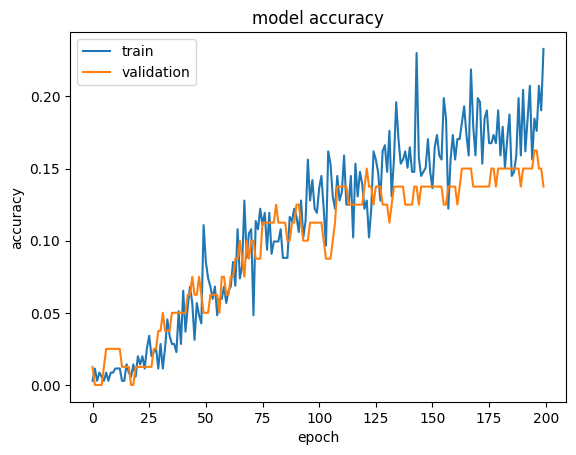

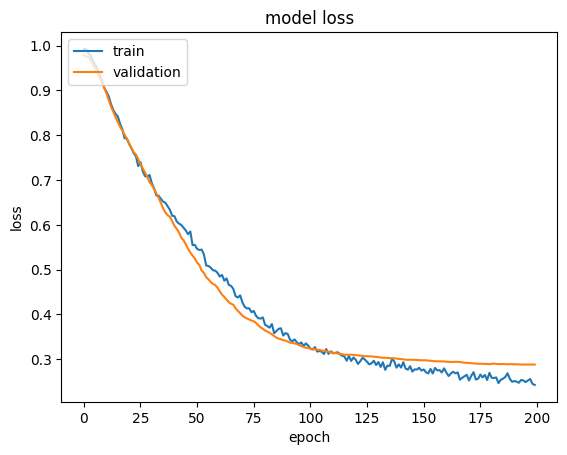

<Figure size 640x480 with 0 Axes>

In [13]:

model2.save_weights(save_path + 'Wt_' + name + '.h5')

print(train_summary.history.keys())

plt.plot(train_summary.history['accuracy'])
plt.plot(train_summary.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()
plt.savefig(save_path + 'Acc_' + name + '.png')

plt.plot(train_summary.history['loss'])
plt.plot(train_summary.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()
plt.savefig(save_path + 'Loss_' + name + '.png')

In [14]:
attribute_length = 300

test_seen_loc = matcontent['test_seen_loc'].squeeze() - 1
print(test_seen_loc, len(test_seen_loc))

test_unseen_loc = matcontent['test_unseen_loc'].squeeze() - 1
print(test_unseen_loc, len(test_unseen_loc))

test_seen_images = images[test_seen_loc]
print(test_seen_images.shape)

test_unseen_images = images[test_unseen_loc]
print(test_unseen_images.shape)

test_seen_attributes = feat_w2v[test_seen_loc]
print(test_seen_attributes, test_seen_attributes.shape)

test_unseen_attributes = feat_w2v[test_unseen_loc]
print(test_unseen_attributes, test_unseen_attributes.shape)

[ 8971  8570  1473 ... 10612  7664  5895] 1764
[  178   179   180 ... 11785 11786 11787] 2967
(1764, 224, 224, 3)
(2967, 224, 224, 3)
[[-0.02581787 -0.00866699 -0.16503906 ... -0.00897217  0.08129883
  -0.05566406]
 [-0.29919434 -0.06689453 -0.35546875 ... -0.0874939   0.07836914
   0.07202148]
 [ 0.01849365 -0.02313232 -0.02172852 ...  0.00891113  0.01473999
   0.06140137]
 ...
 [-0.06933594  0.01692708 -0.09887695 ... -0.03468831  0.17447917
   0.16210938]
 [ 0.0088501  -0.07775879 -0.11328125 ...  0.09301758  0.04568481
   0.18286133]
 [-0.10437012 -0.05603027 -0.19042969 ... -0.17822266 -0.08935547
  -0.0430603 ]] (1764, 300)
[[ 0.16186523  0.09733073  0.08235677 ... -0.08654785  0.06054688
   0.12939453]
 [ 0.16186523  0.09733073  0.08235677 ... -0.08654785  0.06054688
   0.12939453]
 [ 0.16186523  0.09733073  0.08235677 ... -0.08654785  0.06054688
   0.12939453]
 ...
 [-0.07950846  0.02083333  0.06225586 ... -0.09082031  0.00813802
   0.01546224]
 [-0.07950846  0.02083333  0.0622

In [15]:
test_seen_gen = DataGenerator(test_seen_images, test_seen_attributes, batch_size)
model2.evaluate(test_seen_gen, steps = len(test_seen_gen)//batch_size, verbose = 1)

test_unseen_gen = DataGenerator(test_unseen_images, test_unseen_attributes, batch_size)
model2.evaluate(test_unseen_gen, steps = len(test_unseen_gen)//batch_size, verbose = 1)

11/11 [==============================] - 1s 44ms/step - loss: 0.5498 - accuracy: 0.0966


[0.5498207807540894, 0.09659090638160706]

In [16]:
attribute_length = 300

test_seen_loc = matcontent['test_seen_loc'].squeeze() - 1
print(test_seen_loc, len(test_seen_loc))

test_unseen_loc = matcontent['test_unseen_loc'].squeeze() - 1
print(test_unseen_loc, len(test_unseen_loc))

test_seen_images = images[test_seen_loc]
print(test_seen_images.shape)

test_unseen_images = images[test_unseen_loc]
print(test_unseen_images.shape)

test_seen_attributes = feat_w2v[test_seen_loc]
print(test_seen_attributes, test_seen_attributes.shape)

test_unseen_attributes = feat_w2v[test_unseen_loc]
print(test_unseen_attributes, test_unseen_attributes.shape)

[ 8971  8570  1473 ... 10612  7664  5895] 1764
[  178   179   180 ... 11785 11786 11787] 2967
(1764, 224, 224, 3)
(2967, 224, 224, 3)
[[-0.02581787 -0.00866699 -0.16503906 ... -0.00897217  0.08129883
  -0.05566406]
 [-0.29919434 -0.06689453 -0.35546875 ... -0.0874939   0.07836914
   0.07202148]
 [ 0.01849365 -0.02313232 -0.02172852 ...  0.00891113  0.01473999
   0.06140137]
 ...
 [-0.06933594  0.01692708 -0.09887695 ... -0.03468831  0.17447917
   0.16210938]
 [ 0.0088501  -0.07775879 -0.11328125 ...  0.09301758  0.04568481
   0.18286133]
 [-0.10437012 -0.05603027 -0.19042969 ... -0.17822266 -0.08935547
  -0.0430603 ]] (1764, 300)
[[ 0.16186523  0.09733073  0.08235677 ... -0.08654785  0.06054688
   0.12939453]
 [ 0.16186523  0.09733073  0.08235677 ... -0.08654785  0.06054688
   0.12939453]
 [ 0.16186523  0.09733073  0.08235677 ... -0.08654785  0.06054688
   0.12939453]
 ...
 [-0.07950846  0.02083333  0.06225586 ... -0.09082031  0.00813802
   0.01546224]
 [-0.07950846  0.02083333  0.0622

In [17]:
model2.load_weights(save_path + 'bw_' + name + '.h5')

test_seen_gen = DataGenerator(test_seen_images, test_seen_attributes, batch_size)
model2.evaluate(test_seen_gen, steps = len(test_seen_gen)//batch_size, verbose = 1)

test_unseen_gen = DataGenerator(test_unseen_images, test_unseen_attributes, batch_size)
model2.evaluate(test_unseen_gen, steps = len(test_unseen_gen)//batch_size, verbose = 1)


11/11 [==============================] - 1s 44ms/step - loss: 0.5486 - accuracy: 0.0966


[0.5486451387405396, 0.09659090638160706]

# Results


visualFT_to_class_w2vT1_300_embedding_noFT_1024_CUB_100eph_adam_cosine_16bch_0.001lr
[Pretrained ResNet101 is finetuned fully, w2v of 300 length extracted, negative values are kept as it is, average is taken if there are two words, additional: (Dense 1024, batchnorm), weights of new_model is not updated, adam optimizer, lr = 0.001, cosine loss (-1 to 1)]

training: 
Epoch 100/100
loss: -0.7325 - accuracy: 0.1449 - val_loss: -0.6460 - val_accuracy: 0.0750

test seen: loss: -0.6327 - accuracy: 0.1146
test unseen: loss: -0.4208 - accuracy: 0.0455

With best weights
test seen: loss: -0.6298 - accuracy: 0.1146
test unseen: loss: -0.4207 - accuracy: 0.0568


visualFT_to_class_w2vT1_300_embedding_noFT_1024_512_CUB_200eph_adam_cosine_16bch_0.001lr
[Pretrained ResNet101 is finetuned fully, w2v of 300 length extracted, negative values are kept as it is, average is taken if there are two words, additional: (Dense 1024, batchnorm, dense 512, batchnorm), weights of new_model is not updated, adam optimizer, lr = 0.001, cosine loss (-1 to 1)]

training: 
Epoch 200/200
loss: -0.8671 - accuracy: 0.2756 - val_loss: -0.7040 - val_accuracy: 0.1750

test seen: loss: -0.6741 - accuracy: 0.0938
test unseen: loss: -0.4207 - accuracy: 0.0568

With best weights
test seen: loss: -0.6721 - accuracy: 0.1042
test unseen: loss: -0.4264 - accuracy: 0.0511


visualFT_to_class_w2vT1_300_embedding_noFT_1024_512_CUB_200eph_adam_cosine2_16bch_0.001lr
[Pretrained ResNet101 is finetuned fully, w2v of 300 length extracted, negative values are kept as it is, average is taken if there are two words, additional: (Dense 1024, batchnorm, dense 512, batchnorm), weights of new_model is not updated, adam optimizer, lr = 0.001, cosine loss modified (0 to 1)]

training: 
Epoch 200/200
loss: 0.1934 - accuracy: 0.3068 - val_loss: 0.3110 - val_accuracy: 0.1875

test seen: loss: 0.3337 - accuracy: 0.0833
test unseen: loss: 0.5714 - accuracy: 0.0568

With best weights
test seen: loss: 0.3353 - accuracy: 0.0833 
test unseen: loss: 0.5714 - accuracy: 0.0511

visualFT_to_class_w2vT1_300_embedding_noFT_1024_512_d0.2_CUB_100eph_adam_cosine2_16bch_0.001lr
[Pretrained ResNet101 is finetuned fully, w2v of 300 length extracted, negative values are kept as it is, average is taken if there are two words, additional: (Dense 1024, batchnorm, drop 0.2, dense 512, batchnorm, drop 0.2), weights of new_model is not updated, adam optimizer, lr = 0.001, cosine loss modified (0 to 1)]

training: 
Epoch 200/200
loss: 0.2426 - accuracy: 0.2330 - val_loss: 0.2881 - val_accuracy: 0.1375

test seen: loss: 0.3289 - accuracy: 0.1458
test unseen: loss: 0.5498 - accuracy: 0.0966

With best weights
test seen: loss: 0.3295 - accuracy: 0.1354
test unseen: loss: 0.5486 - accuracy: 0.0966